We will start by taking a look at a simple convnet example that classifies the MNIST digits.
The following shows an example of a basic Convnet; a stack of Conv2D and MaxPooling2D layers.
And as we mostly do, we will use the functional API to build the model:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
inputs = keras.Input(shape=(28, 28, 1))    # (shape=(image_height, image_width, image_channels)), not including the batch dim.

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs) #filters=32 means the layer will learn 32 feature detectors like edges, shapes etc.
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)   # kernel size is the size of the filter window, 3 * 3
x = layers.MaxPooling2D(pool_size=2)(x)                              # pooling reduces the spatial size for better learning
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

A convnet takes input tensors of shape(image_height, image_width, image_channel) without including the batch dimension. Here, we will configure the convnet to process inputs of size (28, 28, 1) — the format of the MNIST images. with 1 representing grayscale.

Lets display the architecture of our convent.

In [4]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        11,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,202 (407.04 KB)

 Trainable params: 104,202 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

You can see each output of the Conv2D and Maxpooling layer is a rank-3 tensor, with the filter argument passed to the Conv2D layer controlling the number of channels.

After the last Conv2D layer, we ended up with (3, 3, 128) output shape. that is a 3 by 3 feature map with 128 channels. Then we feed this output layer into a densely connected classifer that processes 1D vectors. So for them to be compatible, we flatten them out to 1D before adding the dense layer.

Now lets train our convnet using the mnist dataset. we will use the sparse_categorical_crossentropy because our labels are integers

In [5]:
from tensorflow.keras.datasets import mnist

In [6]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"])

model.fit(train_images, train_labels, epochs=5, batch_size=64)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8807 - loss: 0.3750
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9847 - loss: 0.0505
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9897 - loss: 0.0305
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9928 - loss: 0.0242
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9948 - loss: 0.0175


In [7]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9881 - loss: 0.0375
Test accuracy: 0.991


We can see we have an accuracy as high as 99.1%. This works better than the densely connnected model explored in earlier chapters. This is because of features like filters and Maxpooling — more details in the book.

## Training convnets from scratch on a small dataset

we will classify images as dogs and cats in a dataset containing 5000 pictures of cats and dogs(2500 cats, and 2500 pics of dogs).

We will first naively train 2000 images from scratch without regularization, to set a baseline for what can be achieved. Before we then explore data augmentation to improve the model.

In the next section, we will explore *feature extraction with a pretrained model* and *fine tuning a pretrained model*, all of which will improve our model immensely.

Lets download the data set from kaggle. But doing that, I will need to authenticate myself on kaggel using the kaggle token. Lets do it :

In [8]:
import json

In [9]:
token = {
     'username': 'mainasaid93',
     'key': 'KGAT_d2c2edae0d4e484013aec1c00e95764c'
 }

with open("kaggle.json", "w") as t:         # creates a json file called kaggle.json, 'w' write mode
  json.dump(token, t)                # dumps the token (the dictionary above) into the file t. in a proper json format.

!mkdir ~/.kaggle              # creating a kaggle folder
!cp kaggle.json ~/.kaggle/   # coppying the key file to it.
!chmod 600 ~/.kaggle/kaggle.json  # making it only readable by the user, that is myself in this case.

In [10]:
!kaggle datasets list

ref                                                  title                                         size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------  --------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                             Heart Disease                                 3491  2025-12-11 15:29:14.327000           2114        207  1.0              
ahmeduzaki/wind-and-solar-energy-production-dataset  Wind & Solar Energy Production Dataset      395372  2026-01-02 21:06:22.780000              0         38  1.0              
kundanbedmutha/exam-score-prediction-dataset         Exam Score Prediction Dataset               325454  2025-11-28 07:29:01.047000           5863        251  1.0              
neurocipher/student-performance                      Student Performance                          49705  2025-12-12

This shows everything has worked. Let me now download the dataset needed for this model.

In [11]:
!kaggle competitions download -c dogs-vs-cats

401 Client Error: Unauthorized for url: https://www.kaggle.com/api/v1/competitions/data/download-all/dogs-vs-cats


The competition has officically ended so I cannot join, that is why the above code will not work. To work with the dataset for practice like i am doing, just download the datasets — done by only changing *competitions* with *datasets* in the code.

In [12]:
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 52% 114M/218M [00:00<00:00, 1.17GB/s]
100% 218M/218M [00:00<00:00, 836MB/s] 


In [13]:
# ! unzip -qq cat-and-dog.zip -d cat-and-dog  # unzips it to a folder named cat-and-dog

Now instead of downloading the data anytime i want to continue with it on colab, I will download it on my system and upload it on google drive. this way i have it readily available for use. lets do it.

In [14]:
import os, shutil, pathlib, zipfile

I want to make my folder structure same with the one in the book.by doing so, I will also practice how this libararies are used. Remember i could have done it while creating the zip file, I am doing more (not necessary) to practice working with the os, pathlib, and shutil libarary.

### creating the book style


In [15]:
old_path = "/content/drive/MyDrive/cats_vs_dogs_small"
new_path = "/content/drive/MyDrive/cats_vs_dogs_original"

os.rename(old_path, new_path)

print("Folder renamed successfully!")
print(new_path)

Folder renamed successfully!
/content/drive/MyDrive/cats_vs_dogs_original


In [16]:
new_small = "/content/drive/MyDrive/cats_vs_dogs_small"
os.makedirs(new_small, exist_ok=True)

Now I have it like it is in the book. so we continue with the codes in the book.

Recap: I first downloaded the the raw data, extracted it and move it into the the folder. i did some more steps to work with the pathlib and os just for practice.

In [17]:
os.makedirs("/content/drive/MyDrive/train", exist_ok=True)

Now lets copy the data into the new train folder:

In [18]:
# cats_src = "/content/drive/MyDrive/cats_vs_dogs_original/training_set/training_set/cats"
# dogs_src = "/content/drive/MyDrive/cats_vs_dogs_original/training_set/training_set/dogs"

# train_dir = "/content/drive/MyDrive/train"

# # Copy cat images
# for i, fname in enumerate(sorted(os.listdir(cats_src))):
#     if fname.lower().endswith(".jpg"):
#         shutil.copyfile(
#             os.path.join(cats_src, fname),
#             os.path.join(train_dir, f"cat.{i}.jpg")
#         )

# # Copy dog images
# for i, fname in enumerate(sorted(os.listdir(dogs_src))):
#     if fname.lower().endswith(".jpg"):
#         shutil.copyfile(
#             os.path.join(dogs_src, fname),
#             os.path.join(train_dir, f"dog.{i}.jpg")
#         )

In [19]:
#original_directory = pathlib.Path("cat-and-dog/training_set/training_set") # path to the direcotry where our origin dataset was stored
#new_base_dir = pathlib.Path("cats_and_dogs_small")  # directory where our small dataset will be stored.

In [20]:
files = os.listdir("/content/drive/MyDrive/train")
print(len(files))

8005


Lets me inspect the content of our dataset.

In [21]:
print(files[:20])

['dog.3006.jpg', 'dog.3007.jpg', 'dog.3008.jpg', 'dog.3009.jpg', 'dog.3010.jpg', 'dog.3011.jpg', 'dog.3012.jpg', 'dog.3013.jpg', 'dog.3014.jpg', 'dog.3015.jpg', 'dog.3016.jpg', 'dog.3017.jpg', 'dog.3018.jpg', 'dog.3019.jpg', 'dog.3020.jpg', 'dog.3021.jpg', 'dog.3022.jpg', 'dog.3023.jpg', 'dog.3024.jpg', 'dog.3025.jpg']


In [22]:
print(files[-20:])

['cat.991.jpg', 'cat.992.jpg', 'cat.993.jpg', 'cat.994.jpg', 'cat.995.jpg', 'cat.996.jpg', 'cat.997.jpg', 'cat.998.jpg', 'cat.999.jpg', 'cat.1000.jpg', 'cat.1001.jpg', 'cat.1002.jpg', 'cat.1003.jpg', 'cat.1004.jpg', 'cat.1005.jpg', 'cat.1.jpg', 'cat.2.jpg', 'cat.3.jpg', 'cat.4.jpg', 'cat.5.jpg']


In [23]:
cats_count = 0
dogs_counts = 0
for i in files:
  if i.startswith("cat"):
    cats_count += 1
  elif i.startswith("dog"):
    dogs_counts += 1

print(f"cats: {cats_count}")
print(f"dogs: {dogs_counts}")

cats: 4000
dogs: 4005


Or a more cleaner/pythonic approach:

In [24]:
cats_count = [cats for cats in files if cats.startswith("cat")]
dogs_counts = [dogs for dogs in files if dogs.startswith("dog")]

print(f"length of cat pictures: {len(cats_count)}")
print(f"length of dog pictures: {len(dogs_counts)}")

length of cat pictures: 4000
length of dog pictures: 4005


So we have 4000 cat pictures and 4005 dog pictures. that is almost split in halve. remember we are not going to use all of the images. Just 5000 for training, validation, and testing out of the 8005 total we have.

copying images to training, validation, and test directories:

In [25]:
original_dir = pathlib.Path("/content/drive/MyDrive/train")  #path to the directory where the original data was uncompressed.
new_base_dir = pathlib.Path("/content/drive/MyDrive/cats_vs_dogs_small") # directory where we will store our smaller dataset.

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir, exist_ok=True)

    all_files = sorted([f for f in os.listdir(original_dir) if f.startswith(category)])
    selected_files = all_files[start_index:end_index]

    for fname in selected_files:
      dst = dir/fname
      if dst.exists():
        print(f"{dst} already exists")
        continue
      shutil.copyfile(src=original_dir / fname,
                      dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

In [26]:
print(original_dir)
print(new_base_dir)

/content/drive/MyDrive/train
/content/drive/MyDrive/cats_vs_dogs_small


I have made some changes in my code to suit my directories on google drive. Also, if you check the make_subset function, you will see that my indexing method is different from  that of the book.This is because the book expects the data numbering to be serial with increament of 1. while the one i uploaded is not. so i used alphabetical order instead.

Now lets build our model. The rescaling() layer will rescale the images (whose value are originally in the [0,255] range) to the [0,1] range.

In [27]:
from tensorflow import keras
from tensorflow.keras import layers

In [28]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Lets see how the dimensions of the feature maps change with every successive layer.

In [29]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

Now lets compile our model:

In [30]:
model.compile(loss = "binary_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

### Data preprocessing

We will use the image_dataset_from_direcotry() from keras to read the images(read more from the book to understand how it works more). Lets see:

But just before doing that, lets view a single image from our directory>

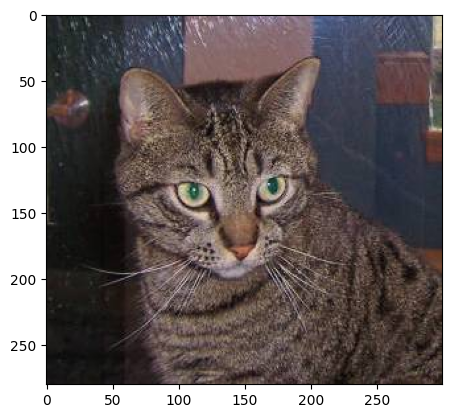

In [31]:
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt

image_path = "/content/drive/MyDrive/cats_vs_dogs_small/train/cat/cat.1.jpg"
img = load_img(image_path)
plt.imshow(img)
plt.show()

lets see the shape of the image;

In [32]:
import numpy as np
image_arr = np.array(img)
print(image_arr.shape)

(280, 300, 3)


Now we have seen how the images look like and its shape, lets go ahead and process them:

In [33]:
from tensorflow.keras.utils import image_dataset_from_directory

In [34]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [35]:
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


As you can see, it has returned the files found in each of the train, validation and test folders in the directory.  

Before we continue, let us take a look at the  *TENSORFLOW DATASET OBJECT*:

Dataset class exposes a functional-style API for modifying datasets. lets take a look at an example: we will consider 1000 sample where each sample is a vector of size 16:

In [36]:
import numpy as np
import tensorflow as tf

random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers) # from_tensorflow_slices() can be used to create a Dataset from a Numpy array, or a tuple or dict.
for  i, element in enumerate(dataset):
  print(element.shape)
  if i >=2:
    break

(16,)
(16,)
(16,)


You can see so far our dataset just yielded single samples. We can use the
.batch() method to batch the data:

In [37]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
  print(element.shape)
  if i >= 2:
    break

(32, 16)
(32, 16)
(32, 16)


Now we have it in batches of 32. we have access t a range of dataset methods. lets look at the .map() method, which applies arbitrary transformation to each element of the dataset.

lets use it to reshape the elements in our toy dataset from shape(16,) to shape (4,4):

In [38]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i,  element in enumerate(reshaped_dataset):
  print(element.shape)
  if i >= 2:
    break

(4, 4)
(4, 4)
(4, 4)


we will explore more map() actions as we proceed

Lets look at the output of one of these dataset objects:

In [39]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


 You can see it yielded batches of  180 * 180 RBG images of shape((32, 180, 180, 3)) and integer labels of shape (shape(32,)). 32 is the size of the batch.

 Now lets fit() our model: using the validation_data argument in fit() to  monitor validation metrics on a seperate dataset object. we will also use the Model_checkpoint to save the model after each epoch, configuring it with the path specifying where to save the file. we will also save a new file by overiding the previous one only when the current value of the loss is lower than any previous one. so its "*save only the best*". This ensures we don't have to train a new model with lower number of epochs when it starts overfitting. we can just reload our saved file.

#### fitting the model using a dataset

In [ ]:
# callbacks = [keras.callbacks.ModelCheckpoint(
#      filepath = "/content/drive/MyDrive/cats_vs_dogs_small/convnet_from_scratch.keras",
#      save_best_only=True,
#      monitor="val_loss"
#  )]

# history = model.fit(train_dataset, epochs=30,
#                      validation_data=validation_dataset,
#                      callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.5177 - loss: 0.6974 - val_accuracy: 0.5000 - val_loss: 0.7306
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.5608 - loss: 0.6880 - val_accuracy: 0.6300 - val_loss: 0.6704
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.6193 - loss: 0.6561 - val_accuracy: 0.5960 - val_loss: 0.6618
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.6624 - loss: 0.6257 - val_accuracy: 0.6630 - val_loss: 0.6242
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.6833 - loss: 0.6042 - val_accuracy: 0.5940 - val_loss: 0.8718
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.7102 - loss: 0.5678 - val_accuracy: 0.7110 - val_loss: 0.5787
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.7276 - loss: 0.5437 - val_accuracy: 0.6990 - val_loss: 0.6162
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.7456 - loss: 0.5299 - val_accuracy: 0.7160 - v

Lets run some files check:

In [40]:
from google.colab import files
uploaod = files.upload()

Saving history.npy to history.npy


In [41]:
shutil.move("history.npy", "/content/drive/MyDrive/cats_vs_dogs_original/history.npy")

'/content/drive/MyDrive/cats_vs_dogs_original/history.npy'

In [42]:
uploaod = files.upload()

Saving convnet_from_scratch.keras to convnet_from_scratch.keras


In [43]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [44]:
shutil.move("convnet_from_scratch.keras", "/content/drive/MyDrive/cats_vs_dogs_original/convnet_from_scratch.keras")

'/content/drive/MyDrive/cats_vs_dogs_original/convnet_from_scratch.keras'

In [45]:
!ls -lh /content/drive/MyDrive/cats_vs_dogs_original

total 7.7M
-rw------- 1 root root 7.7M Jan  7 09:32 convnet_from_scratch.keras
-rw------- 1 root root 1.4K Jan  7 09:30 history.npy
drwx------ 2 root root 4.0K Jan  6 16:52 test
drwx------ 2 root root 4.0K Jan  6 16:22 train
drwx------ 2 root root 4.0K Jan  6 16:51 validation


In [46]:
path = "/content/drive/MyDrive/cats_vs_dogs_original"
print(os.listdir(path))

['train', 'validation', 'test', 'history.npy', 'convnet_from_scratch.keras']


In [47]:
#model.save("/content/drive/MyDrive/cats_vs_dogs_original/convnet_from_scratch.keras")

In [48]:
#np.save("/content/drive/MyDrive/cats_vs_dogs_original/history.npy", history.history)

Lets load our saved loss and validation history:

In [49]:
history_dict = np.load("/content/drive/MyDrive/cats_vs_dogs_original/history.npy", allow_pickle=True).item()
print(history_dict.keys())
print(history_dict['loss'])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
[0.6935570240020752, 0.6818423867225647, 0.6533328890800476, 0.6195122599601746, 0.5974931120872498, 0.5531075596809387, 0.527296781539917, 0.5074294805526733, 0.4619501829147339, 0.4151466488838196, 0.37128716707229614, 0.31298595666885376, 0.2608511447906494, 0.2224408984184265, 0.14712980389595032, 0.12836657464504242, 0.09300421178340912, 0.08749178797006607, 0.061895884573459625, 0.06927716732025146, 0.05751953646540642, 0.05784934014081955, 0.04709994047880173, 0.05550283193588257, 0.03618040308356285, 0.033136412501335144, 0.06512194871902466, 0.03421565145254135, 0.04530210793018341, 0.04920440912246704]


In [50]:
# checks !
for root, dirs, files in os.walk("/content/drive/MyDrive", topdown=True):
  if "history.npy" in files:
    print("FOUND:", os.path.join(root, "history.npy"))
    print(dirs)

FOUND: /content/drive/MyDrive/cats_vs_dogs_original/history.npy
['train', 'validation', 'test']


In [51]:
for root, dirs, files in os.walk("/content/drive/MyDrive", topdown=True):
    if "convnet_from_scratch.keras" in files:
        print("FOUND:", os.path.join(root, "convnet_from_scratch.keras"))


FOUND: /content/drive/MyDrive/cats_vs_dogs_original/convnet_from_scratch.keras


Now lets plot the loss and accuracy of the model over the training and validation data during training:

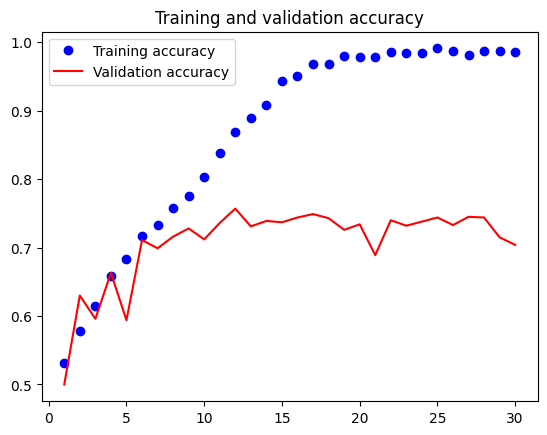

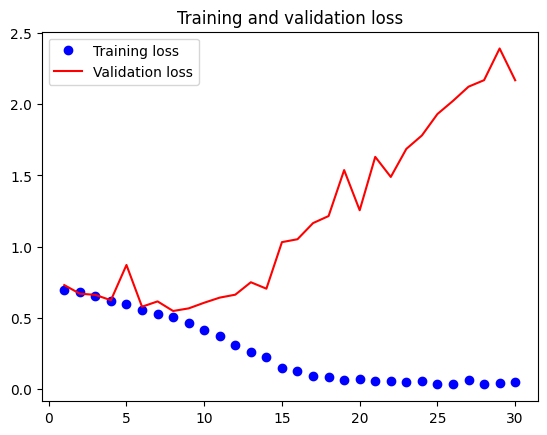

In [52]:
import matplotlib.pyplot as plt

accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

As we can see, the validation accuracy picks at around 75% while the training accuracy continues to increase till around 90%. Similary, the validation loss reached its minimum at around 8 epochs and then shoots up, while the training keeps decreasing as as the training continues. This plots are typical case of overfitting.

Now lets check the test accuracy. We will now reload the model form its saved file, i.e *convnet_from_scratch.keras* file, to evaluate it as it was before it started overfitting. Remember this is our best performing model as explained earlier.

In [53]:
test_model = keras.models.load_model("/content/drive/MyDrive/cats_vs_dogs_original/convnet_from_scratch.keras") # model file from my directory.
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"The test accuracy for the model is: {test_acc:.3f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.7192 - loss: 2.0982
The test accuracy for the model is: 0.710


Our test accuracy is 0.710, which is around 71%. Because our training sample is relatively small(2000 iamges), so overfitting will be our number one concern.

And that takes us to data augmentation. This involves generating more training data from existing training samples by augmenting the samples via a number of random transformations that yield a believable-looking image.

### Data Augmentation.

In keras, this can be done by adding a number of data augmentation layers at the start of your model: the following sequential model chains several random image transformations.


In [54]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),  # horizontal flipping to a random 50% of the images that goes through it.
    layers.RandomRotation(0.1),  # rotates the input images by a random value to a range of [-10%, +10%] of 360%
    layers.RandomZoom(0.2)   # zooms in/out of the image by a random factor in the range[-20%, +20%].
])

Lets take a look at the augmented images:

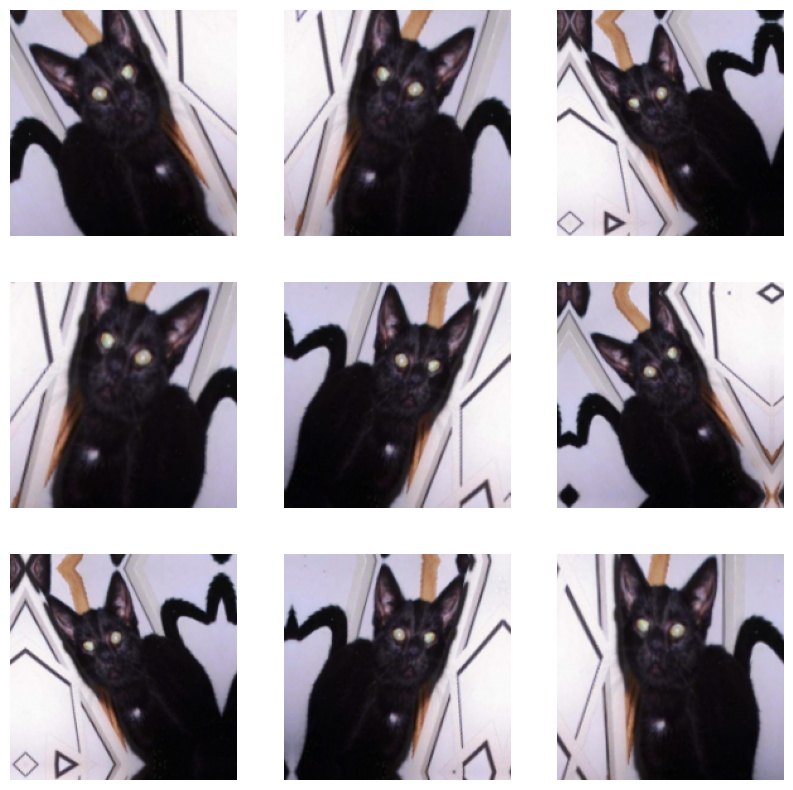

In [55]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):  # take(N) is used to only sample N batches from the dataset.
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [56]:
# checks!
for images, labels in train_dataset.take(1):
  print(labels.shape)
  print(images.shape)
  print(labels[:10])

(32,)
(32, 180, 180, 3)
tf.Tensor([1 0 0 0 1 1 0 1 0 1], shape=(10,), dtype=int32)


Lets define a new convnet that includes image augmentation and dropout.

We are adding dropout because data augmentation alone will not get rid of overfitting, since the augmented images come from small number of original images, making it heavily intercorrelated. Lets see:

In [57]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [58]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Now lets train out model. Because we expect overfitting to occur much later during training, we wil increase the number of epochs to 100.

In [ ]:
# callbacks = [keras.callbacks.ModelCheckpoint(
#     filepath="convnet_from_scratch_with_augmentation.keras",
#     save_best_only=True,
#     monitor="val_loss"
# )]

# history1 = model.fit(train_dataset, epochs=100,
#                     validation_data=validation_dataset,
#                     callbacks=callbacks)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - accuracy: 0.4860 - loss: 0.7908 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.5047 - loss: 0.6935 - val_accuracy: 0.5010 - val_loss: 0.6920
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.5362 - loss: 0.6949 - val_accuracy: 0.4990 - val_loss: 0.7052
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.5544 - loss: 0.6866 - val_accuracy: 0.5850 - val_loss: 0.6654
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.5698 - loss: 0.6774 - val_accuracy: 0.6250 - val_loss: 0.6442
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.6203 - loss: 0.6525 - val_accuracy: 0.6200 - val_loss: 0.6489
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.6590 - loss: 0.6294 - val_accuracy: 0.6560 - val_loss: 0.6291
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.6656 - loss: 0.6131 - 

In [ ]:
model.save("/content/drive/MyDrive/cats_vs_dogs_original/convnet_from_scratch_with_augmentation.keras")
np.save("/content/drive/MyDrive/cats_vs_dogs_original/history1.npy", history1.history)

In [59]:
from google.colab import files
uploaod = files.upload()

Saving history1.npy to history1.npy


In [60]:
shutil.move("history1.npy", "/content/drive/MyDrive/cats_vs_dogs_original/history1.npy")

'/content/drive/MyDrive/cats_vs_dogs_original/history1.npy'

In [61]:
!ls -lh /content/drive/MyDrive/cats_vs_dogs_original

total 7.7M
-rw------- 1 root root 7.7M Jan  7 09:32 convnet_from_scratch.keras
-rw------- 1 root root 3.9K Jan  7 09:39 history1.npy
-rw------- 1 root root 1.4K Jan  7 09:30 history.npy
drwx------ 3 root root 4.0K Jan  6 16:52 test
drwx------ 4 root root 4.0K Jan  6 16:22 train
drwx------ 4 root root 4.0K Jan  6 16:51 validation


In [62]:
uploaod = files.upload()

Saving convnet_from_scratch_with_augmentation.keras to convnet_from_scratch_with_augmentation.keras


In [63]:
shutil.move("convnet_from_scratch_with_augmentation.keras", "/content/drive/MyDrive/cats_vs_dogs_original/convnet_from_scratch_with_augmentation.keras")

'/content/drive/MyDrive/cats_vs_dogs_original/convnet_from_scratch_with_augmentation.keras'

In [64]:
path = "/content/drive/MyDrive/cats_vs_dogs_original"
print(os.listdir(path))

['train', 'validation', 'test', 'history.npy', 'convnet_from_scratch.keras', 'history1.npy', 'convnet_from_scratch_with_augmentation.keras']


load files

In [65]:
# load the history of the model
history_1_dict = np.load("/content/drive/MyDrive/cats_vs_dogs_original/history1.npy", allow_pickle=True).item()
print(history_dict.keys())
print(history_dict['loss'])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
[0.6935570240020752, 0.6818423867225647, 0.6533328890800476, 0.6195122599601746, 0.5974931120872498, 0.5531075596809387, 0.527296781539917, 0.5074294805526733, 0.4619501829147339, 0.4151466488838196, 0.37128716707229614, 0.31298595666885376, 0.2608511447906494, 0.2224408984184265, 0.14712980389595032, 0.12836657464504242, 0.09300421178340912, 0.08749178797006607, 0.061895884573459625, 0.06927716732025146, 0.05751953646540642, 0.05784934014081955, 0.04709994047880173, 0.05550283193588257, 0.03618040308356285, 0.033136412501335144, 0.06512194871902466, 0.03421565145254135, 0.04530210793018341, 0.04920440912246704]


In [66]:
# load the second model with data augmentation and dropout
test_model_enhanced = keras.models.load_model("/content/drive/MyDrive/cats_vs_dogs_original/convnet_from_scratch.keras") # model file from my directory.

Now that we have our  enhanced models saved and uploaded, lets proceed....